In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import urllib.request
import ast
import datetime
import time
from joblib import Parallel, delayed
import nltk
from nltk.corpus import stopwords
import stylecloud
from PIL import Image

# ignore all wanrings
import warnings
warnings.filterwarnings("ignore")

# pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# category names from Youtube API
category_mapping = {1: 'Film & Animation',
                    2: 'Autos & Vehicles',
                    10: 'Music',
                    15: 'Pets & Animals',
                    17: 'Sports',
                    18: 'Short Movies',
                    19: 'Travel & Events',
                    20: 'Gaming',
                    21: 'Videoblogging',
                    22: 'People & Blogs',
                    23: 'Comedy',
                    24: 'Entertainment',
                    25: 'News & Politics',
                    26: 'Howto & Style',
                    27: 'Education',
                    28: 'Science & Technology',
                    29: 'Nonprofits & Activism',
                    30: 'Movies',
                    31: 'Anime/Animation',
                    32: 'Action/Adventure',
                    33: 'Classics',
                    34: 'Comedy',
                    35: 'Documentary',
                    36: 'Drama',
                    37: 'Family',
                    38: 'Foreign',
                    39: 'Horror',
                    40: 'Sci-Fi/Fantasy',
                    41: 'Thriller',
                    42: 'Shorts',
                    43: 'Shows',
                    44: 'Trailers'
                   }

# Reading Data File and Preprocessing

In [3]:
df = pd.DataFrame()
for file in os.listdir('data'):
    temp = pd.read_csv('data/' + file)
    temp['rank'] = range(1,201)
    df = df.append(temp, ignore_index = True)

df['categoryIdName'] = df['categoryId'].apply(lambda x: category_mapping[x])  # category mapping
df['trending_date'] = pd.to_datetime(df['trending_date'], utc = True, format = '%y.%d.%m') + datetime.timedelta(hours=20) # extract trending time
df['publishedAt'] = pd.to_datetime(df['publishedAt']) + datetime.timedelta(hours = 7)  #convert UTC to WIB

In [4]:
# no duplicates and keeps only the first occurance of trending (for publish date, etc)
no_dups_f = df.sort_values('trending_date', ascending = True)
no_dups_f = no_dups_f.drop_duplicates(subset='video_id', keep='first')

# no duplicates and keeps last occurance for views, comments, etc
no_dups_l = df.sort_values('trending_date', ascending = True)
no_dups_l = no_dups_l.drop_duplicates(subset='video_id', keep='last')

In [5]:
# 200 videos each day
df.shape

(600, 18)

In [6]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,rank,categoryIdName
0,XFTu8vyC-PY,AURELIE HERMANSYAH - KEPASTIAN (Official Music...,2020-07-03 08:30:11+00:00,UCHpZSZi1rkM7NiayhxXw-cw,MyMusic Records,10,2020-07-08 20:00:00+00:00,MyMusic|My Music|Music Video|Official Clip|MyM...,10087738,696952,28604,471713,https://i.ytimg.com/vi/XFTu8vyC-PY/default.jpg,False,False,Cara Unduh Nada Sambung PribadiAurelie Hermans...,1,Music
1,Ujb-gvqsoi0,Red Velvet - IRENE & SEULGI 'Monster' MV,2020-07-07 10:00:05+00:00,UCEf_Bc-KVd7onSeifS3py9g,SMTOWN,10,2020-07-08 20:00:00+00:00,아이린|슬기|아이린&슬기|monster|몬스터|monster mv|레드벨벳|레드벨벳...,14465217,1912382,34266,175179,https://i.ytimg.com/vi/Ujb-gvqsoi0/default.jpg,False,False,Red Velvet - IRENE & SEULGI's 1st Mini Album M...,2,Music
2,NZ2_mOTc4TM,Milan 4-2 Juventus | Ronaldo Goal Not Enough a...,2020-07-08 05:35:53+00:00,UCBJeMCIeLQos7wacox4hmLQ,Serie A,17,2020-07-08 20:00:00+00:00,AC Milan|calcio|Rebic|Milan Juventus|Juventus|...,9695590,186749,6705,10502,https://i.ytimg.com/vi/NZ2_mOTc4TM/default.jpg,False,False,Juventus missed the chance to move 10 points c...,3,Sports
3,32si5cfrCNc,BLACKPINK - 'How You Like That' DANCE PERFORMA...,2020-07-06 07:00:00+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2020-07-08 20:00:00+00:00,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,34979014,3260509,52657,155862,https://i.ytimg.com/vi/32si5cfrCNc/default.jpg,False,False,▶️ MORE INFO ABOUT DANCE COVER CONTEST : https...,4,Music
4,-ogKtrQs3c0,jurnalrisa 90 - MENGENALKAN MAMAT DAN UJANG KE...,2020-07-07 21:00:00+00:00,UCKFC1LYWw1fbe9LNfm2vEPg,jurnalrisa,22,2020-07-08 20:00:00+00:00,[none],1648795,167782,948,15598,https://i.ytimg.com/vi/-ogKtrQs3c0/default.jpg,False,False,Selamat datang di #jurnalrisaSaya dan tim berk...,5,People & Blogs


# Scrape Social Blade Info

In [7]:
uniq_channelid = np.unique(df['channelId'])
base_url = 'https://socialblade.com/youtube/channel/'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}
all_results = {}

In [8]:
def scrape_info(channelid):
    results = {}
    private = False
    print(base_url + channelid)
    try:
        req = urllib.request.Request(url = base_url + channelid, headers = headers) 
        html = urllib.request.urlopen(req).read()
    except:  #Users set to private!!!
        private = True

    if private == False:   
        soup = BeautifulSoup(html, 'html.parser')

        rank = soup.find(id='socialblade-user-content').find_all('div')[2]
        rank = re.search(r'\>\s+(.+)\s+\<', str(rank)).group(1)
        results['rank'] = rank

        top_bar = soup.find(id='YouTubeUserTopInfoBlock').find_all('div')        
        num_videos = int(top_bar[2].find_all('span')[1].text.replace(',','')) 
        curr_subs = top_bar[3].find_all('span')[1].text
        total_views = int(top_bar[4].find_all('span')[1].text.replace(',',''))
        country = top_bar[5].find_all('span')[1].text
        channel_type = top_bar[6].find_all('span')[2].text  # because there is the question mark bubble
        created = top_bar[7].find_all('span')[1].text

        results['num_videos'] = num_videos
        results['curr_subs'] = curr_subs
        results['total_views'] = total_views
        results['country'] = country
        results['channel_type'] = channel_type
        results['created'] = created

        past_view_gains = {}

        for i in range(14):
            view_date = soup.find(id='socialblade-user-content').find_all('div')[53 + i*10].text.strip()
            temp = soup.find(id='socialblade-user-content').find_all('div')[59 + i*10].text[1:]
            past_view_gains[view_date] = int(temp.replace('-','0').replace(',',''))
        results['past_view_gains'] = past_view_gains


        # scrape interactive charts Highcharts from social blade
        chart_data = []
        all_scripts = soup.find_all("script")
        for script in all_scripts:
            if 'Highcharts.chart' in script.text:
                # found data match            
                script_data = re.findall(r'series:\s+\[{\s.+\s+.+\s.+', script.text)
                # len of script_data = 4
                # 1. Monthly subs gain
                # 2. Montly views
                # 3. Weekly subs gain
                # 4. Weekly view 
                for ind, data in enumerate(script_data):
                    try:
                        temp = re.search(r'data:\s+(\[\[.+\]\])', data).group(1)
                        temp = np.array(ast.literal_eval(temp))
                        date_end = [datetime.datetime.fromtimestamp(int(str(elem)[:-3])).strftime('%Y-%m-%d') for elem in temp[:,0]]
                        res = {}
                        for idx, e in enumerate(date_end):
                            res[e] = temp[:,1][idx]
                        chart_data.append(res)
                    except:
                        chart_data.append({})
        results['charts'] = chart_data
    else:
        results = {}
    
    # store results in all_results
    all_results[channelid] = results

In [9]:
# scrape social blade in parallel
Parallel(n_jobs=-1, require='sharedmem')(delayed(scrape_info)(i) for i in uniq_channelid);

https://socialblade.com/youtube/channel/UC-3zv-XrPz28_W9oRd9q1tQhttps://socialblade.com/youtube/channel/UC0k3T5AJYvKnuc52bB7rJTAhttps://socialblade.com/youtube/channel/UC0zTYTRQe77tnOIS03HaNeghttps://socialblade.com/youtube/channel/UC15VpzK4og3NLmCVZQOroFw



https://socialblade.com/youtube/channel/UC1FIzF2QOcmFlSzPkT4Ln7Ahttps://socialblade.com/youtube/channel/UC1US-uenbxK9RbPgW8G3AsA

https://socialblade.com/youtube/channel/UC1nqMqjwWkcN80yfHM6Hcow
https://socialblade.com/youtube/channel/UC24_Z2L-8Ki183AI9zJJzNQ
https://socialblade.com/youtube/channel/UC2sVRtimSUdDN2myZ6Cf03w
https://socialblade.com/youtube/channel/UC2wZJuuD_WA9ps2FORco1EQ
https://socialblade.com/youtube/channel/UC34xi8JB1AKSotPUKHywbaA
https://socialblade.com/youtube/channel/UC35HKvKYPkri4Grd5KXl3wQ
https://socialblade.com/youtube/channel/UC3IZKseVpdzPSBaWxBxundA
https://socialblade.com/youtube/channel/UC3Pa0DVzVkqEN_CwsNMapqg
https://socialblade.com/youtube/channel/UC3TWomTUdYuMjkWI4PkQXeg
https://socialblade.com/y

In [10]:
sbdf = pd.DataFrame()
sbdf['channelid'] = all_results.keys()

def get_data(x, attr):
    if len(x.keys()) == 0:
        return ''
    else:
        return x[attr]

def get_chart_data(x, i):
    if len(x.keys()) == 0:
        return np.nan
    
    if len(x['charts']) == 2:
        if i == 0 or i == 1:
            return np.nan
        elif i == 3:
            return x['charts'][0]
        else:
            return x['charts'][1]
    elif len(x['charts']) == 4:
        return x['charts'][i]
    else:
        return np.nan
        

sbdf['rank'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x],'rank'))
sbdf['num_videos'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x],'num_videos'))
sbdf['curr_subs'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x],'curr_subs'))
sbdf['total_views'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x],'total_views'))
sbdf['country'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x],'country'))
sbdf['channel_type'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x],'channel_type'))
sbdf['past_view_gains'] = sbdf['channelid'].apply(lambda x: get_data(all_results[x], 'past_view_gains'))
sbdf['monthly_subs_gain'] = sbdf['channelid'].apply(lambda x: get_chart_data(all_results[x], 0))
sbdf['monthly_views'] = sbdf['channelid'].apply(lambda x: get_chart_data(all_results[x], 1))
sbdf['weekly_subs_gain'] = sbdf['channelid'].apply(lambda x: get_chart_data(all_results[x], 2))
sbdf['weekly_view'] = sbdf['channelid'].apply(lambda x: get_chart_data(all_results[x], 3))


def map_channel_categories(x):
    if x == 'Autos':
        return 'Autos & Vehicles'
    elif x == 'Film':
        return 'Film & Animation'
    elif x == 'Games':
        return 'Gaming'
    elif x == 'Howto':
        return 'Howto & Style'
    elif x == 'News':
        return 'News & Politics'
    elif x == 'Nonprofit':
        return 'Nonprofit & Activism'
    elif x == 'People':
        return 'People & Blogs'
    elif x == 'Travel':
        return 'Travel & Events'
    elif x == 'Comedy' or x == 'Education' or x == 'Entertainment' or x == 'Music' or x == 'Sports':
        return x
    else:
        return ''
    
sbdf['channel_type'] = sbdf['channel_type'].apply(lambda x: map_channel_categories(x))
sbdf.head()

,channelid,rank,num_videos,curr_subs,total_views,country,channel_type,past_view_gains,monthly_subs_gain,monthly_views,weekly_subs_gain,weekly_view
0,UC0k3T5AJYvKnuc52bB7rJTA,A-,26,2.07M,417252644,ID,Music,"{'2020-06-27': 2262606, '2020-06-28': 2104569,...","{'2020-06-30': 260000, '2020-05-31': 90000, '2...","{'2020-06-30': 37415651, '2020-05-31': 2200491...","{'2019-06-24': 8482, '2019-07-01': 8137, '2019...","{'2019-06-24': 2101365, '2019-07-01': 2248478,..."
1,UC-3zv-XrPz28_W9oRd9q1tQ,B+,505,839K,164471688,,Entertainment,"{'2020-06-27': 307086, '2020-06-28': 336924, '...","{'2020-06-30': 50000, '2020-05-31': 45000, '20...","{'2020-06-30': 9825643, '2020-05-31': 8323658,...","{'2019-06-24': 5107, '2019-07-01': 5831, '2019...","{'2019-06-24': 748497, '2019-07-01': 742260, '..."
2,UC0zTYTRQe77tnOIS03HaNeg,B,74,111K,5413252,ID,,"{'2020-06-27': 133435, '2020-06-28': 93651, '2...","{'2020-06-30': 42400, '2020-05-31': 29373}","{'2020-06-30': 2299515, '2020-05-31': 1266503}","{'2020-05-04': 790, '2020-05-12': 1470, '2020-...","{'2020-05-04': 29014, '2020-05-12': 55154, '20..."
3,UC15VpzK4og3NLmCVZQOroFw,B+,481,1.19M,197968097,ID,Comedy,"{'2020-06-27': 757278, '2020-06-28': 518838, '...","{'2020-06-30': 80000, '2020-05-31': 50000, '20...","{'2020-06-30': 15030071, '2020-05-31': 1545024...","{'2019-06-24': 13885, '2019-07-01': 7184, '201...","{'2019-06-24': 2220514, '2019-07-01': 1837098,..."
4,UC1FIzF2QOcmFlSzPkT4Ln7A,B,288,1.24M,81898299,ID,Entertainment,"{'2020-06-27': 45075, '2020-06-28': 74243, '20...","{'2020-06-30': 30000, '2020-05-31': 40000, '20...","{'2020-06-30': 2028141, '2020-05-31': 2648065,...","{'2019-06-24': 4292, '2019-07-01': 11717, '201...","{'2019-06-24': 331266, '2019-07-01': 774667, '..."


In [11]:
df = pd.merge(df, sbdf, left_on = 'channelId', right_on = 'channelid', how = 'left')
no_dups_f = pd.merge(no_dups_f, sbdf, left_on = 'channelId', right_on = 'channelid', how = 'left')
no_dups_l = pd.merge(no_dups_l, sbdf, left_on = 'channelId', right_on = 'channelid', how = 'left')

In [12]:
### FILL MISSING CHANNEL GENRE WITH VIDEO TYPE!!!
def fill_missing_channel_type(x):
    if x['channel_type'] != '':
        return x['channel_type']
    else:
        return x['categoryIdName']
    
    
df['channel_type'] = df.apply(lambda x: fill_missing_channel_type(x), axis = 1)
no_dups_f['channel_type'] = no_dups_f.apply(lambda x: fill_missing_channel_type(x), axis = 1)
no_dups_l['channel_type'] = no_dups_f.apply(lambda x: fill_missing_channel_type(x), axis = 1)

In [13]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,rank_x,categoryIdName,channelid,rank_y,num_videos,curr_subs,total_views,country,channel_type,past_view_gains,monthly_subs_gain,monthly_views,weekly_subs_gain,weekly_view
0,XFTu8vyC-PY,AURELIE HERMANSYAH - KEPASTIAN (Official Music...,2020-07-03 08:30:11+00:00,UCHpZSZi1rkM7NiayhxXw-cw,MyMusic Records,10,2020-07-08 20:00:00+00:00,MyMusic|My Music|Music Video|Official Clip|MyM...,10087738,696952,28604,471713,https://i.ytimg.com/vi/XFTu8vyC-PY/default.jpg,False,False,Cara Unduh Nada Sambung PribadiAurelie Hermans...,1,Music,UCHpZSZi1rkM7NiayhxXw-cw,B+,480,1.34M,636222597,ID,Music,"{'2020-06-27': 276477, '2020-06-28': 239530, '...","{'2020-06-30': 20000, '2020-05-31': 20000, '20...","{'2020-06-30': 7365673, '2020-05-31': 6412452,...","{'2019-06-24': 5855, '2019-07-01': 5912, '2019...","{'2019-06-24': 2325729, '2019-07-01': 2554447,..."
1,Ujb-gvqsoi0,Red Velvet - IRENE & SEULGI 'Monster' MV,2020-07-07 10:00:05+00:00,UCEf_Bc-KVd7onSeifS3py9g,SMTOWN,10,2020-07-08 20:00:00+00:00,아이린|슬기|아이린&슬기|monster|몬스터|monster mv|레드벨벳|레드벨벳...,14465217,1912382,34266,175179,https://i.ytimg.com/vi/Ujb-gvqsoi0/default.jpg,False,False,Red Velvet - IRENE & SEULGI's 1st Mini Album M...,2,Music,UCEf_Bc-KVd7onSeifS3py9g,A,3583,23.2M,17018749260,,Music,"{'2020-06-27': 9816428, '2020-06-28': 8937279,...","{'2020-06-30': 300000, '2020-05-31': 500000, '...","{'2020-06-30': 294319002, '2020-05-31': 340257...","{'2019-06-24': 73154, '2019-07-01': 68392, '20...","{'2019-06-24': 55669077, '2019-07-01': 5021807..."
2,NZ2_mOTc4TM,Milan 4-2 Juventus | Ronaldo Goal Not Enough a...,2020-07-08 05:35:53+00:00,UCBJeMCIeLQos7wacox4hmLQ,Serie A,17,2020-07-08 20:00:00+00:00,AC Milan|calcio|Rebic|Milan Juventus|Juventus|...,9695590,186749,6705,10502,https://i.ytimg.com/vi/NZ2_mOTc4TM/default.jpg,False,False,Juventus missed the chance to move 10 points c...,3,Sports,UCBJeMCIeLQos7wacox4hmLQ,A,19021,4.92M,1490071189,IT,Sports,"{'2020-06-27': 8293077, '2020-06-28': 5642759,...","{'2020-06-30': 320000, '2020-05-31': 0, '2020-...","{'2020-06-30': 59321440, '2020-05-31': 6794552...","{'2019-06-24': 117, '2019-07-01': 569, '2019-0...","{'2019-06-24': 1324887, '2019-07-01': 1483252,..."
3,32si5cfrCNc,BLACKPINK - 'How You Like That' DANCE PERFORMA...,2020-07-06 07:00:00+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2020-07-08 20:00:00+00:00,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,34979014,3260509,52657,155862,https://i.ytimg.com/vi/32si5cfrCNc/default.jpg,False,False,▶️ MORE INFO ABOUT DANCE COVER CONTEST : https...,4,Music,UCOmHUn--16B90oW2L6FRR3A,A+,274,41.2M,10091659584,KR,Music,"{'2020-06-27': 81522088, '2020-06-28': 4606823...","{'2020-06-30': 3900000, '2020-05-31': 1000000,...","{'2020-06-30': 641952551, '2020-05-31': 265334...","{'2019-06-24': 258678, '2019-07-01': 267138, '...","{'2019-06-24': 68420898, '2019-07-01': 6972493..."
4,-ogKtrQs3c0,jurnalrisa 90 - MENGENALKAN MAMAT DAN UJANG KE...,2020-07-07 21:00:00+00:00,UCKFC1LYWw1fbe9LNfm2vEPg,jurnalrisa,22,2020-07-08 20:00:00+00:00,[none],1648795,167782,948,15598,https://i.ytimg.com/vi/-ogKtrQs3c0/default.jpg,False,False,Selamat datang di #jurnalrisaSaya dan tim berk...,5,People & Blogs,UCKFC1LYWw1fbe9LNfm2vEPg,A-,154,4.28M,445401721,ID,People & Blogs,"{'2020-06-27': 903125, '2020-06-28': 642344, '...","{'2020-06-30': 170000, '2020-05-31': 100000, '...","{'2020-06-30': 28066070, '2020-05-31': 2207261...","{'2019-06-24': 18734, '2019-07-01': 28767, '20...","{'2019-06-24': 1452926, '2019-07-01': 3039308,..."


Trending by category

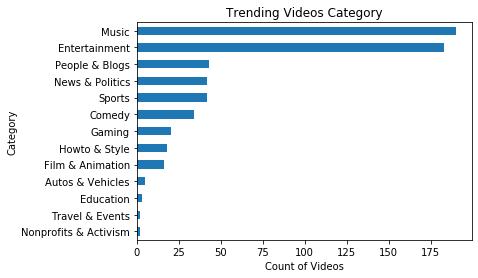

In [14]:
df['categoryIdName'].value_counts().plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.xlabel('Count of Videos')
plt.ylabel('Category')
plt.title('Trending Videos Category');

Num Trending videos by channel for today

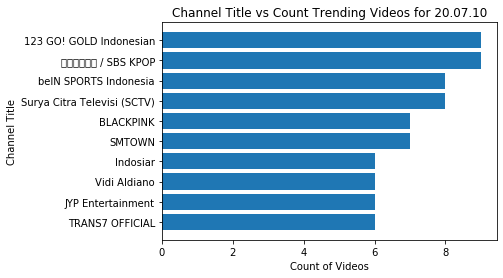

In [15]:
trending_count = df[df['trending_date'] == '2020-07-10']
trending_count = df.groupby(['channelTitle']).agg('count')['video_id'].reset_index()
trending_count.sort_values('video_id', inplace = True, ascending = False)
trending_count = trending_count[0:10]

plt.barh(trending_count['channelTitle'], trending_count['video_id'])
plt.gca().invert_yaxis()
plt.xlabel('Count of Videos')
plt.ylabel('Channel Title')
plt.title('Channel Title vs Count Trending Videos for 20.07.10');

Trending Length

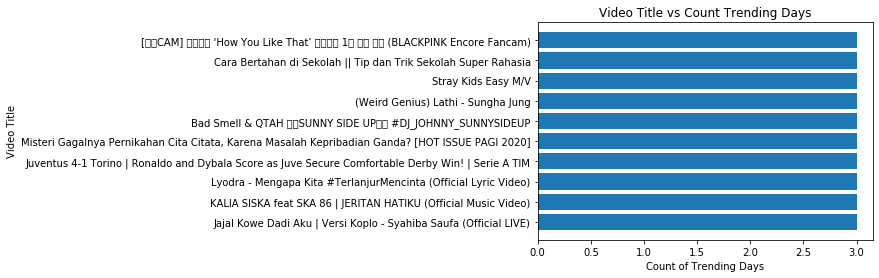

In [16]:
trend_length = df.groupby(['video_id']).agg('count')['trending_date'].reset_index()
trend_length.sort_values('trending_date', inplace = True, ascending = False)
trend_length = trend_length[0:10]
temp = df[['video_id', 'title']].drop_duplicates()

trend_length = pd.merge(trend_length, temp, how = 'inner', on = 'video_id')

plt.barh(trend_length['title'], trend_length['trending_date'].astype(int))
plt.gca().invert_yaxis()
plt.xlabel('Count of Trending Days')
plt.ylabel('Video Title')
plt.title('Video Title vs Count Trending Days');

Avg length of publish to first trending

In [17]:
no_dups_f['time_to_trend'] = no_dups_f['trending_date'] - no_dups_f['publishedAt']

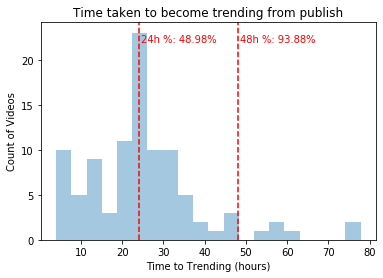

In [18]:
def days_hours_minutes(td):
    days = td.days
    hours = td.seconds //3600
    minutes = (td.seconds//60)%60
    return days * 24 + hours + minutes / 60

temp = no_dups_f[no_dups_f['publishedAt'] >= '2020-07-07'].copy()
temp['time_to_trend'] = temp['time_to_trend'].apply(lambda x: days_hours_minutes(x))
temp['time_to_trend'].hist(bins = 20, alpha = 0.4)
plt.axvline(24, color='r', linestyle='--')
twenty_four = round((temp[temp['time_to_trend'] <= 24].shape[0] / temp.shape[0]) * 100,2)
plt.text(24.5,22, '24h %: ' + str(twenty_four) + '%', color = 'r')
plt.axvline(48, color='r', linestyle='--')
fourty_eight = round((temp[temp['time_to_trend'] <= 48].shape[0] / temp.shape[0]) * 100,2)
plt.text(48.5,22, '48h %: ' + str(fourty_eight) + '%', color = 'r')

plt.xlabel('Time to Trending (hours)')
plt.ylabel('Count of Videos')
plt.title('Time taken to become trending from publish');
plt.grid(b=None);

Publish Hours

In [19]:
def get_publish_hour(x):
    hour = x.hour
    minute = x.minute
    if hour == 24:
        return '00:00'
    if minute >= 45:
        return str(str((hour + 1)) + ':00')
    elif minute >= 15 and minute < 45:
        return str(str(hour) + ':30')
    else:
        return str(str(hour) + ':00')
    

no_dups_f['publish_cat'] = no_dups_f['publishedAt'].apply(lambda x: get_publish_hour(x))

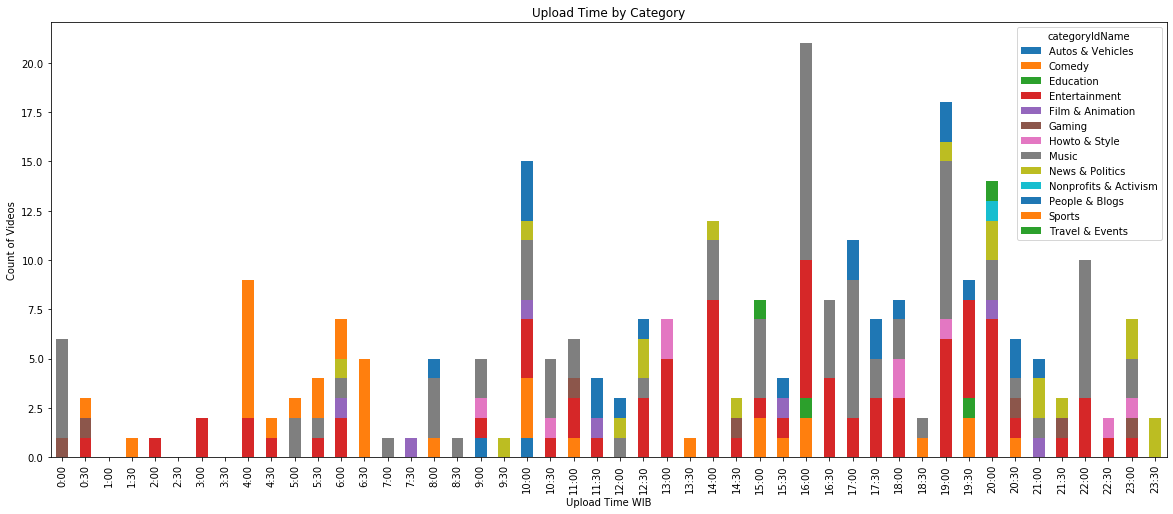

In [20]:
def create_bins():
    ans = []
    for i in range(24):
        ans.append(str(i) + ':00')
        ans.append(str(i) + ':30')
    return ans
bins = create_bins()
count_bins = pd.DataFrame()
count_bins['bins'] = bins

val_counts = no_dups_f.groupby(['publish_cat', 'categoryIdName']).agg('count')['title'].reset_index()
count_bins = pd.merge(count_bins, val_counts, left_on = 'bins', right_on = 'publish_cat', how = 'left')
count_bins.drop(['publish_cat'], axis = 1, inplace = True)
count_bins['title'] = count_bins['title'].fillna(0)
count_bins['title'] = count_bins['title'].astype(int)
bins_pivot = count_bins.pivot(index='bins', columns='categoryIdName', values='title')
bins_pivot = bins_pivot.reindex(bins)
bins_pivot.loc[:,'Autos & Vehicles':].plot.bar(stacked=True, figsize=(20,8))
plt.xlabel('Upload Time WIB')
plt.ylabel('Count of Videos')
plt.title('Upload Time by Category');

Most Viewed Video

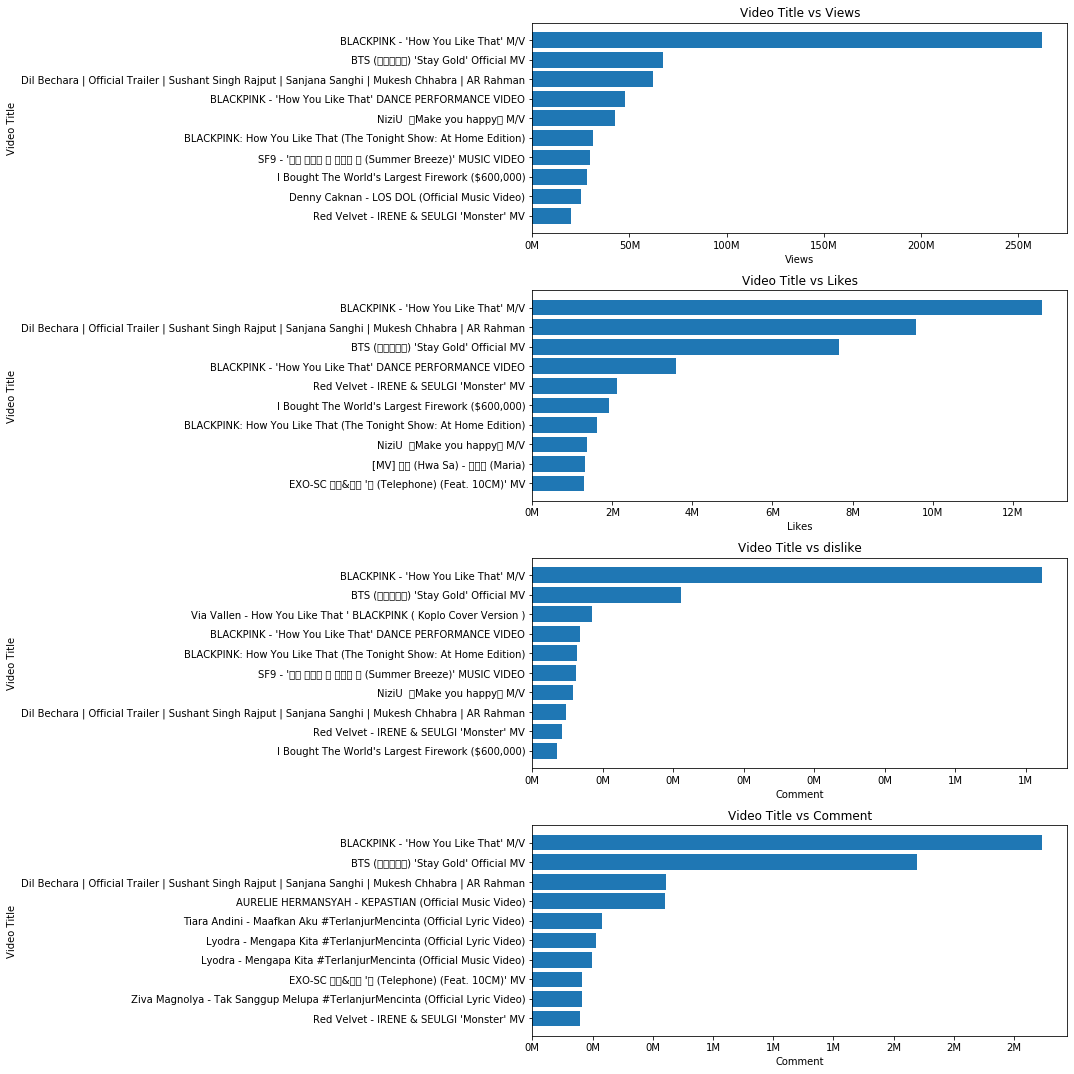

In [21]:
temp = no_dups_l.sort_values('view_count', ascending = False)
temp = temp[0:10]
fig, ax = plt.subplots(4,1, figsize = (15,15))
ax[0].barh(temp['title'], temp['view_count'])
xlabels = ['{:,.0f}'.format(x) + 'M' for x in ax[0].get_xticks()/1000000]
ax[0].invert_yaxis()
ax[0].set_xlabel('Views')
ax[0].set_ylabel('Video Title')
ax[0].set_title('Video Title vs Views');
ax[0].set_xticklabels(xlabels);


temp = no_dups_l.sort_values('likes', ascending = False)
temp = temp[0:10]
ax[1].barh(temp['title'], temp['likes'])
xlabels = ['{:,.0f}'.format(x) + 'M' for x in ax[1].get_xticks()/1000000]
ax[1].invert_yaxis()
ax[1].set_xlabel('Likes')
ax[1].set_ylabel('Video Title')
ax[1].set_title('Video Title vs Likes');
ax[1].set_xticklabels(xlabels);

temp = no_dups_l.sort_values('dislikes', ascending = False)
temp = temp[0:10]
ax[2].barh(temp['title'], temp['dislikes'])
xlabels = ['{:,.0f}'.format(x) + 'M' for x in ax[2].get_xticks()/1000000]
ax[2].invert_yaxis()
ax[2].set_xlabel('Comment')
ax[2].set_ylabel('Video Title')
ax[2].set_title('Video Title vs dislike');
ax[2].set_xticklabels(xlabels);


temp = no_dups_l.sort_values('comment_count', ascending = False)
temp = temp[0:10]
ax[3].barh(temp['title'], temp['comment_count'])
xlabels = ['{:,.0f}'.format(x) + 'M' for x in ax[3].get_xticks()/1000000]
ax[3].invert_yaxis()
ax[3].set_xlabel('Comment')
ax[3].set_ylabel('Video Title')
ax[3].set_title('Video Title vs Comment');
ax[3].set_xticklabels(xlabels);

fig.tight_layout(pad = 1)

Like vs Dislike Ratio

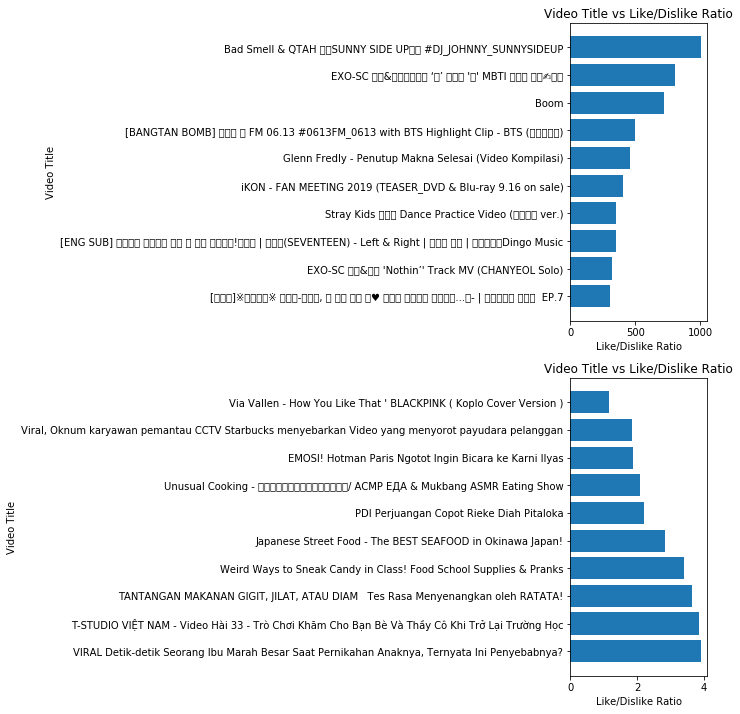

In [22]:
temp = no_dups_l.copy()
temp['like_dislike_ratio'] = temp['likes'] / temp['dislikes']
temp = temp.sort_values('like_dislike_ratio', ascending = False)
temp_1 = temp[0:10]
fig, ax = plt.subplots(2,1, figsize = (10,10))
ax[0].barh(temp_1['title'], temp_1['like_dislike_ratio'])
ax[0].invert_yaxis()
ax[0].set_xlabel('Like/Dislike Ratio')
ax[0].set_ylabel('Video Title')
ax[0].set_title('Video Title vs Like/Dislike Ratio');

temp = temp.sort_values('like_dislike_ratio', ascending = True)
temp_2 = temp[0:10]
ax[1].barh(temp_2['title'], temp_2['like_dislike_ratio'])
ax[1].invert_yaxis()
ax[1].set_xlabel('Like/Dislike Ratio')
ax[1].set_ylabel('Video Title')
ax[1].set_title('Video Title vs Like/Dislike Ratio');

fig.tight_layout(pad = 1)

Channel

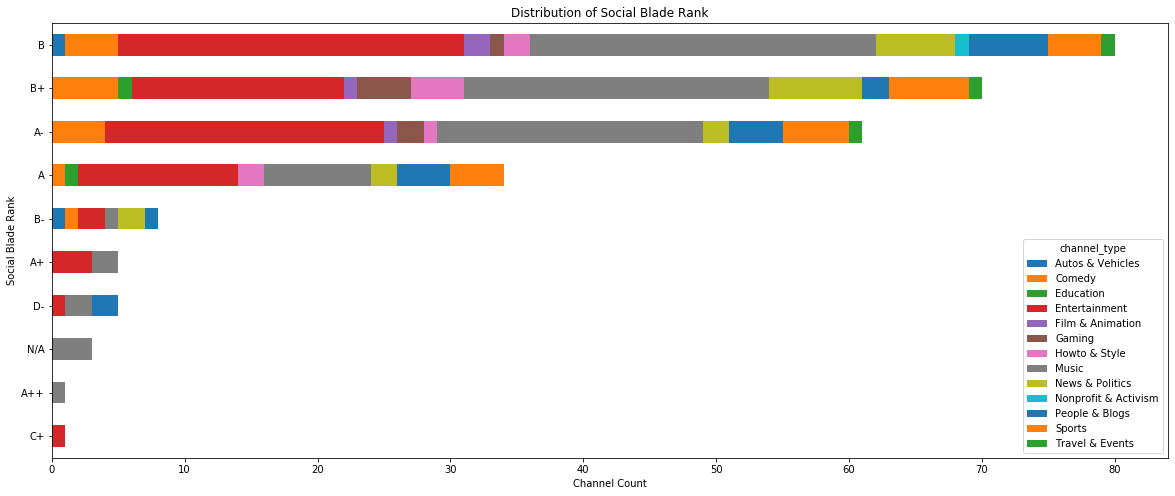

In [23]:
temp = no_dups_l.groupby(['rank_y', 'channel_type']).agg('count')['video_id'].reset_index()
temp.sort_values('video_id', inplace = True, ascending = False)
def replace_empty(x):
    if x == '':
        return 'N/A'
    else:
        return x
    
temp['rank_y'] = temp['rank_y'].apply(lambda x: replace_empty(x))
temp['video_id'] = temp['video_id'].astype(int)
temp = temp.pivot(index='rank_y', columns='channel_type', values='video_id')

a = no_dups_l.groupby(['rank_y']).agg('count')['video_id'].reset_index()
a.sort_values('video_id', inplace = True, ascending = False)
a['rank_y'] = a['rank_y'].apply(lambda x: replace_empty(x))
temp = temp.reindex(a['rank_y'])

temp.plot.barh(stacked=True, figsize=(20,8))
plt.gca().invert_yaxis()
plt.xlabel('Channel Count')
plt.ylabel('Social Blade Rank')
plt.title('Distribution of Social Blade Rank');

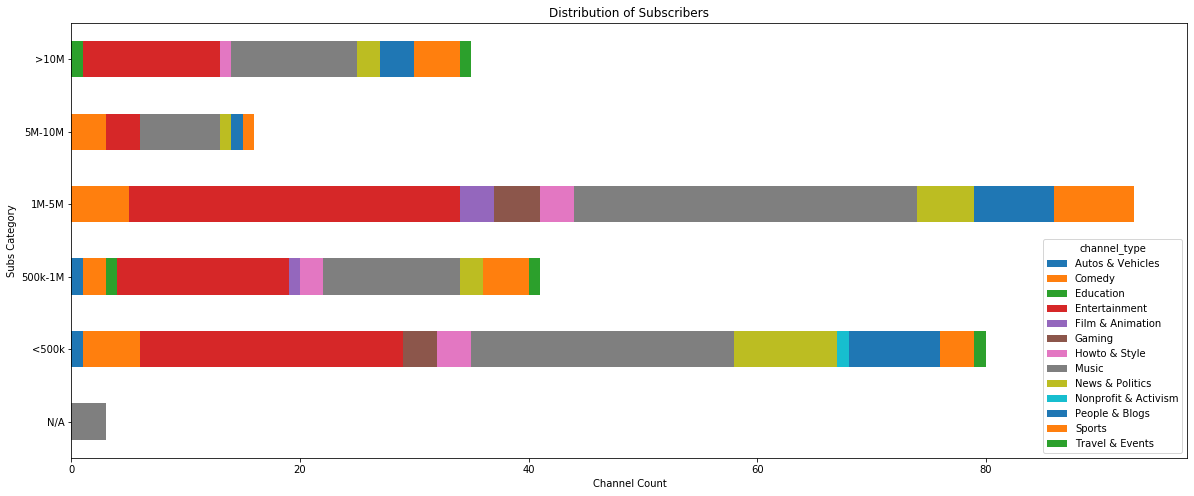

In [24]:
no_dups_l.head()
temp = no_dups_l.copy()

def convert_curr_subs(x):
    curr_subs = x['curr_subs']
    if curr_subs == '':
        return int(-1)
    last_str = curr_subs[-1]
    number = curr_subs[:-1]
    point_pos = -1
    if '.' in number:
        point_pos = 3 - number.index('.')
    
    if last_str == 'K':
        last_str = 1000
    elif last_str == 'M':
        last_str = 1000000
    
    if point_pos != -1:
        final_num = int(number.replace('.','')) / (10 ** point_pos) * last_str
    else:
        final_num = int(number.replace('.','')) * last_str
    return int(final_num)

def curr_subs_cat(x):
    if x == -1:
        return 'N/A'
    if x <= 500000:
        return '<500k'
    elif x <= 1000000:
        return '500k-1M'
    elif x <= 5000000:
        return '1M-5M'
    elif x <= 10000000:
        return '5M-10M'
    else:
        return '>10M'

temp['curr_subs'] = temp.apply(lambda x: convert_curr_subs(x), axis = 1)
temp['curr_subs_cat'] = temp['curr_subs'].apply(lambda x: curr_subs_cat(x))

temp = temp.groupby(['curr_subs_cat', 'channel_type']).agg('count')['title'].reset_index()
temp.sort_values('title', inplace = True, ascending = False)

def replace_empty(x):
    if x == '':
        return 'N/A'
    else:
        return x
    
temp['curr_subs_cat'] = temp['curr_subs_cat'].apply(lambda x: replace_empty(x))
temp['title'] = temp['title'].astype(int)
temp = temp.pivot(index='curr_subs_cat', columns='channel_type', values='title')
temp = temp.reindex(['>10M', '5M-10M', '1M-5M', '500k-1M', '<500k', 'N/A'])

temp.plot.barh(stacked=True, figsize=(20,8))
plt.gca().invert_yaxis()
plt.xlabel('Channel Count')
plt.ylabel('Subs Category')
plt.title('Distribution of Subscribers');

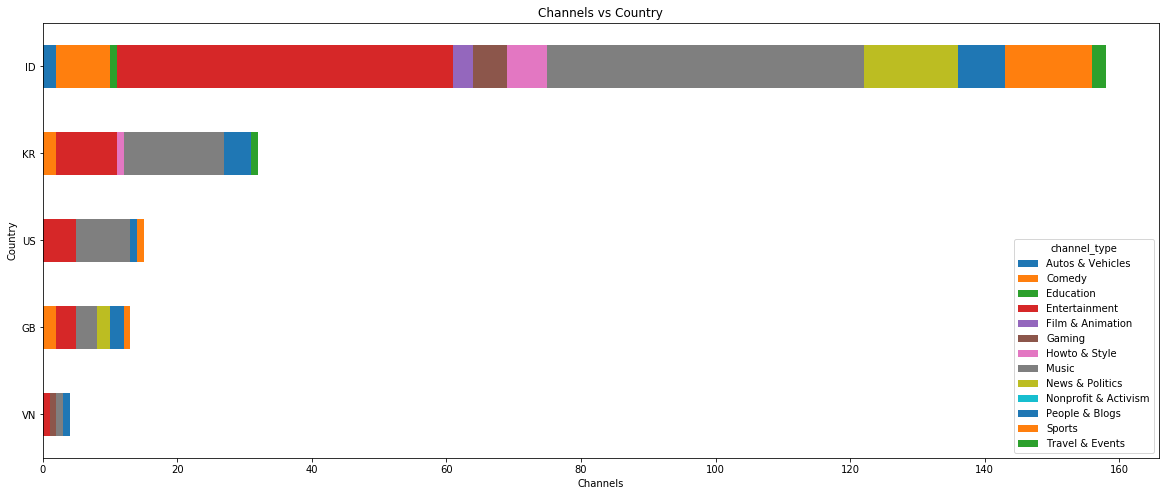

In [25]:
trending_count = no_dups_l.groupby(['country', 'channel_type']).agg('count')['video_id'].reset_index()
trending_count.sort_values('video_id', inplace = True, ascending = False)
def replace_empty(x):
    if x == '':
        return 'N/A'
    else:
        return x
    
trending_count['country'] = trending_count['country'].apply(lambda x: replace_empty(x))
trending_count['video_id'] = trending_count['video_id'].astype(int)
trending_count = trending_count.pivot(index='country', columns='channel_type', values='video_id')

a = no_dups_l.groupby(['country']).agg('count')['video_id'].reset_index()
a.sort_values('video_id', inplace = True, ascending = False)
a['country'] = a['country'].apply(lambda x: replace_empty(x))
trending_count = trending_count.reindex(a['country'])
trending_count = trending_count[trending_count.index != 'N/A'] 
trending_count = trending_count[0:5]

trending_count.plot.barh(stacked=True, figsize=(20,8))
plt.gca().invert_yaxis()
plt.xlabel('Channels')
plt.ylabel('Country')
plt.title('Channels vs Country');

Effect of Trending on Views + Subs

In [26]:
top_10 = no_dups_f[no_dups_f['rank_x'].isin(range(1,51))]  #take top50 trending
top_10 = top_10[top_10['trending_date'] < '2020-07-10']  #not including this date because day is not finished

In [27]:
# since there is not enough data, assume that first trending is during publish date and remain that way.
# because from previous analysis, it is said that trending videos tend to be there within 24 hours
# not including publishdate here
def avg_prior(x):
    pub_date = x['publishedAt'].date()
    date_prior = []
    for i in range(1,4):
        temp = pub_date - datetime.timedelta(days=i)
        temp = temp.strftime('%Y-%m-%d')
        date_prior.append(temp)
    
    avg_views = []
    for elem in date_prior:
        if elem in x['past_view_gains']:
            avg_views.append(x['past_view_gains'][elem])    
    return np.average(avg_views)

# after trending take average of after published to current trending date
# include publish date here
def after_trend(x):
    pub_date = x['publishedAt'].date()
    trend_date = x['trending_date'].date()
    
    dates_after = []
    if trend_date == pub_date:
        dates_after.append(trend_date.strftime('%Y-%m-%d'))
    else:
        diff_days = (trend_date - pub_date).days
        for i in range(diff_days + 1):
            temp = pub_date + datetime.timedelta(days=i)
            temp = temp.strftime('%Y-%m-%d')
            dates_after.append(temp)
    
    avg_views = []
    for elem in dates_after:
        if elem in x['past_view_gains']:
            avg_views.append(x['past_view_gains'][elem])    
    return np.average(avg_views)
    

top_10['before_trending'] = top_10.apply(lambda x: avg_prior(x), axis = 1)
top_10['after_trending'] = top_10.apply(lambda x: after_trend(x), axis = 1)
top_10['avg_inc'] = (top_10['after_trending'] - top_10['before_trending']) * 100 / top_10['before_trending']

In [28]:
print('mean', np.nanmean(top_10['avg_inc']), '%')
print('median', np.nanmedian(top_10['avg_inc']), '%')
print('min', np.nanmin(top_10['avg_inc']), '%')
print('max', np.nanmax(top_10['avg_inc']), '%')

mean 129.68986619023917 %
median 70.28927968380043 %
min -74.56817866007667 %
max 1543.0146345250573 %


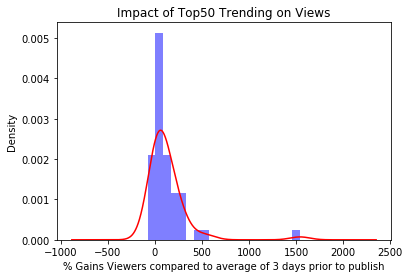

In [29]:
top_10['avg_inc'].hist(bins = 20, color = 'b', alpha = 0.5, density = True)
top_10['avg_inc'].plot.kde(color = 'r')
plt.xlabel('% Gains Viewers compared to average of 3 days prior to publish')
plt.title('Impact of Top50 Trending on Views');

Title and Description Analysis

In [30]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,rank_x,categoryIdName,channelid,rank_y,num_videos,curr_subs,total_views,country,channel_type,past_view_gains,monthly_subs_gain,monthly_views,weekly_subs_gain,weekly_view
0,XFTu8vyC-PY,AURELIE HERMANSYAH - KEPASTIAN (Official Music...,2020-07-03 08:30:11+00:00,UCHpZSZi1rkM7NiayhxXw-cw,MyMusic Records,10,2020-07-08 20:00:00+00:00,MyMusic|My Music|Music Video|Official Clip|MyM...,10087738,696952,28604,471713,https://i.ytimg.com/vi/XFTu8vyC-PY/default.jpg,False,False,Cara Unduh Nada Sambung PribadiAurelie Hermans...,1,Music,UCHpZSZi1rkM7NiayhxXw-cw,B+,480,1.34M,636222597,ID,Music,"{'2020-06-27': 276477, '2020-06-28': 239530, '...","{'2020-06-30': 20000, '2020-05-31': 20000, '20...","{'2020-06-30': 7365673, '2020-05-31': 6412452,...","{'2019-06-24': 5855, '2019-07-01': 5912, '2019...","{'2019-06-24': 2325729, '2019-07-01': 2554447,..."
1,Ujb-gvqsoi0,Red Velvet - IRENE & SEULGI 'Monster' MV,2020-07-07 10:00:05+00:00,UCEf_Bc-KVd7onSeifS3py9g,SMTOWN,10,2020-07-08 20:00:00+00:00,아이린|슬기|아이린&슬기|monster|몬스터|monster mv|레드벨벳|레드벨벳...,14465217,1912382,34266,175179,https://i.ytimg.com/vi/Ujb-gvqsoi0/default.jpg,False,False,Red Velvet - IRENE & SEULGI's 1st Mini Album M...,2,Music,UCEf_Bc-KVd7onSeifS3py9g,A,3583,23.2M,17018749260,,Music,"{'2020-06-27': 9816428, '2020-06-28': 8937279,...","{'2020-06-30': 300000, '2020-05-31': 500000, '...","{'2020-06-30': 294319002, '2020-05-31': 340257...","{'2019-06-24': 73154, '2019-07-01': 68392, '20...","{'2019-06-24': 55669077, '2019-07-01': 5021807..."
2,NZ2_mOTc4TM,Milan 4-2 Juventus | Ronaldo Goal Not Enough a...,2020-07-08 05:35:53+00:00,UCBJeMCIeLQos7wacox4hmLQ,Serie A,17,2020-07-08 20:00:00+00:00,AC Milan|calcio|Rebic|Milan Juventus|Juventus|...,9695590,186749,6705,10502,https://i.ytimg.com/vi/NZ2_mOTc4TM/default.jpg,False,False,Juventus missed the chance to move 10 points c...,3,Sports,UCBJeMCIeLQos7wacox4hmLQ,A,19021,4.92M,1490071189,IT,Sports,"{'2020-06-27': 8293077, '2020-06-28': 5642759,...","{'2020-06-30': 320000, '2020-05-31': 0, '2020-...","{'2020-06-30': 59321440, '2020-05-31': 6794552...","{'2019-06-24': 117, '2019-07-01': 569, '2019-0...","{'2019-06-24': 1324887, '2019-07-01': 1483252,..."
3,32si5cfrCNc,BLACKPINK - 'How You Like That' DANCE PERFORMA...,2020-07-06 07:00:00+00:00,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2020-07-08 20:00:00+00:00,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,34979014,3260509,52657,155862,https://i.ytimg.com/vi/32si5cfrCNc/default.jpg,False,False,▶️ MORE INFO ABOUT DANCE COVER CONTEST : https...,4,Music,UCOmHUn--16B90oW2L6FRR3A,A+,274,41.2M,10091659584,KR,Music,"{'2020-06-27': 81522088, '2020-06-28': 4606823...","{'2020-06-30': 3900000, '2020-05-31': 1000000,...","{'2020-06-30': 641952551, '2020-05-31': 265334...","{'2019-06-24': 258678, '2019-07-01': 267138, '...","{'2019-06-24': 68420898, '2019-07-01': 6972493..."
4,-ogKtrQs3c0,jurnalrisa 90 - MENGENALKAN MAMAT DAN UJANG KE...,2020-07-07 21:00:00+00:00,UCKFC1LYWw1fbe9LNfm2vEPg,jurnalrisa,22,2020-07-08 20:00:00+00:00,[none],1648795,167782,948,15598,https://i.ytimg.com/vi/-ogKtrQs3c0/default.jpg,False,False,Selamat datang di #jurnalrisaSaya dan tim berk...,5,People & Blogs,UCKFC1LYWw1fbe9LNfm2vEPg,A-,154,4.28M,445401721,ID,People & Blogs,"{'2020-06-27': 903125, '2020-06-28': 642344, '...","{'2020-06-30': 170000, '2020-05-31': 100000, '...","{'2020-06-30': 28066070, '2020-05-31': 2207261...","{'2019-06-24': 18734, '2019-07-01': 28767, '20...","{'2019-06-24': 1452926, '2019-07-01': 3039308,..."


In [59]:
def clean_title(x, ret_type):
    no_punc = re.sub(r'[^\w\s]','', x)  #strips all punctuation and emojis
    no_punc = re.sub(r'\s+', ' ', no_punc)  #remove multiple spaces
    if ret_type == 'len':
        return len(no_punc.split(' '))
    
    foreign = []
    korean = re.findall(r'[\uAC00-\uD7AF]+', no_punc) # find korean words
    jpcn = re.findall(r'[\u3000-\u303f\u3040-\u309f\u30a0-\u30ff\uff00-\uff9f\u4e00-\u9faf\u3400-\u4dbf]+', no_punc) #jpcn
    foreign.extend(korean)
    if len(jpcn) >= 1:
        for ind, elem in enumerate(jpcn):
            lenelem = len(elem)
            for i in range(lenelem):
                foreign.append(jpcn[ind][i])   # append character by character for jp and cn
    
    # remove all foreign chars
    no_punc = re.sub(r'[\uAC00-\uD7AF]+', '', no_punc)
    no_punc = re.sub(r'[\u3000-\u303f\u3040-\u309f\u30a0-\u30ff\uff00-\uff9f\u4e00-\u9faf\u3400-\u4dbf]+', '', no_punc)
    no_punc = re.sub(r'[^a-zA-Z\s0-9\u00C0-\u00FF]+','', no_punc)  #remove any remaining foreign chars
    no_punc = re.sub(r'\s+', ' ', no_punc)  #remove multiple spaces
    no_punc = no_punc.split(' ')  #splits by space
    
    # No stopwords removal on title
    no_punc = [i.lower() for i in no_punc]
    no_punc = [word for word in no_punc if word not in stopwords.words('english')]
    no_punc = [word for word in no_punc if word not in stopwords.words('indonesian')]

    no_punc = [elem for elem in no_punc if len(elem) > 1]
    return no_punc

df['title_len'] = df['title'].apply(lambda x: clean_title(x, 'len'))
df['title_cleaned'] = df['title'].apply(lambda x: clean_title(x, 'clean'))

In [60]:
def clean_desc(x):
    if pd.isnull(x) == True:
        return []
    
    no_punc = re.sub(r'https\S+', '', x) # remove all url
    no_punc = re.sub(r'http\S+', '', no_punc) # remove all url
    no_punc = re.sub(r'\S*@\S*\s?','', no_punc) # remove all emails
    no_punc = re.sub(r'[^\w\s]','', no_punc)  #strips all punctuation and emojis
    no_punc = re.sub(r'\s+', ' ', no_punc)  #remove multiple spaces
    no_punc = re.sub(r'_*', '', no_punc) # repalce ____
    no_punc = re.sub(r'[^a-zA-Z\s0-9\u00C0-\u00FF]', '', no_punc)  #remove indian, russian, etc others
    
    foreign = []
    korean = re.findall(r'[\uAC00-\uD7AF]+', no_punc) # find korean words
    jpcn = re.findall(r'[\u3000-\u303f\u3040-\u309f\u30a0-\u30ff\uff00-\uff9f\u4e00-\u9faf\u3400-\u4dbf]+', no_punc) #jpcn
    foreign.extend(korean)
    if len(jpcn) >= 1:
        for ind, elem in enumerate(jpcn):
            lenelem = len(elem)
            for i in range(lenelem):
                foreign.append(jpcn[ind][i])   # append character by character for jp and cn
    
    
    # remove all foreign chars
    no_punc = re.sub(r'[\uAC00-\uD7AF]+', '', no_punc)
    no_punc = re.sub(r'[\u3000-\u303f\u3040-\u309f\u30a0-\u30ff\uff00-\uff9f\u4e00-\u9faf\u3400-\u4dbf]+', '', no_punc)
    no_punc = re.sub(r'[^a-zA-Z\s0-9\u00C0-\u00FF]+','', no_punc)  #remove any remaining foreign chars
    no_punc = re.sub(r'\s+', ' ', no_punc)  #remove multiple spaces
    no_punc = no_punc.split(' ')  #splits by space
    no_punc = [i.lower() for i in no_punc]
    # stopwords removal
    no_punc = [word for word in no_punc if word not in stopwords.words('english')]
    no_punc = [word for word in no_punc if word not in stopwords.words('indonesian')]
    no_punc = [elem for elem in no_punc if len(elem) > 1]

    return no_punc

df['desc_cleaned'] =  df['description'].apply(lambda x: clean_desc(x))

In [124]:
df['title']

0      AURELIE HERMANSYAH - KEPASTIAN (Official Music...
1               Red Velvet - IRENE & SEULGI 'Monster' MV
2      Milan 4-2 Juventus | Ronaldo Goal Not Enough a...
3      BLACKPINK - 'How You Like That' DANCE PERFORMA...
4      jurnalrisa 90 - MENGENALKAN MAMAT DAN UJANG KE...
                             ...                        
595    20 Lagu Penyemangat Pagi Untuk Memulai Aktifit...
596    Zara Thehro Song | Amaal Mallik, Armaan Malik,...
597    Kepastian - Aurelie Hermansyah cover by Della ...
598                                Cintamu Bukan Untukku
599    Gak Kuat Liatnya, Jadi Ikutan Mewek 😭 - Film B...
Name: title, Length: 600, dtype: object

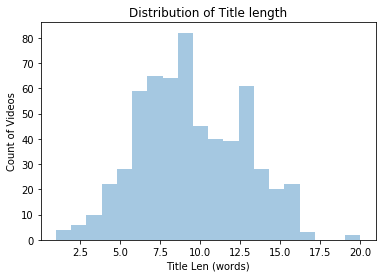

In [61]:
df['title_len'].hist(bins = 20, alpha = 0.4)
plt.xlabel('Title Len (words)')
plt.ylabel('Count of Videos')
plt.title('Distribution of Title length');
plt.grid(b=None);

Text(0.5, 1, 'Correlation Heatmap')

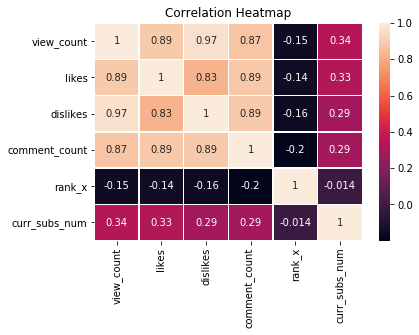

In [63]:
no_dups_l['curr_subs_num'] = no_dups_l.apply(lambda x: convert_curr_subs(x), axis = 1)
heat = no_dups_l[['view_count', 'likes', 'dislikes', 'comment_count', 'rank_x', 'curr_subs_num']].corr()
sns.heatmap(heat, annot=True, linewidths=.5)
plt.title('Correlation Heatmap')

Word Clouds

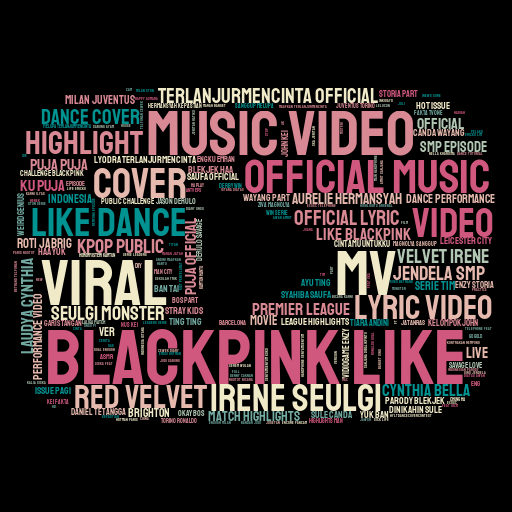

In [64]:
a = df.copy()
a['cleaned_text'] = a['title_cleaned'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(a['cleaned_text'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fab fa-youtube', max_words=200, palette='cartocolors.diverging.TealRose_7', background_color="black", output_name='yt-title-words.png')
Image.open('yt-title-words.png')

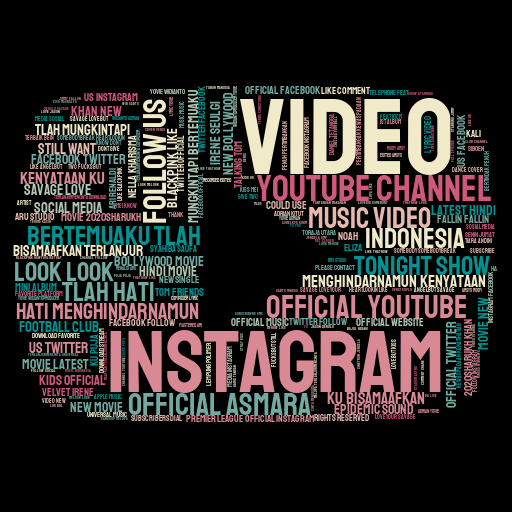

In [65]:
a = df.copy()
a['cleaned_text'] = a['desc_cleaned'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(a['cleaned_text'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fab fa-youtube', max_words=200, palette='cartocolors.diverging.TealRose_7', background_color="black", output_name='yt-desc-words.png')
Image.open('yt-desc-words.png')

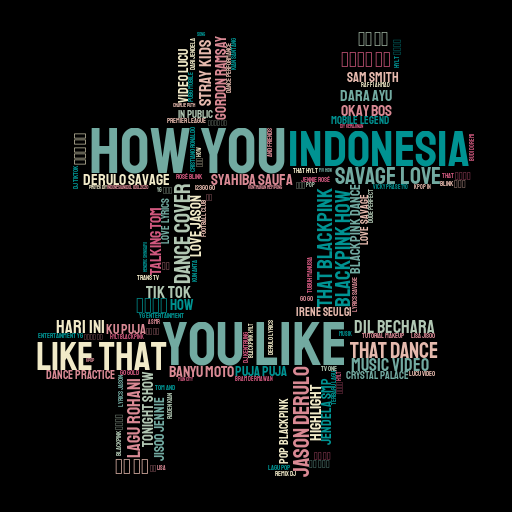

In [66]:
a = df.copy()
def tags_split(x):
    if x == '[none]':
        return []
    else:
        return x.split('|')

a['tags_split'] = a['tags'].apply(lambda x: tags_split(x))
a['cleaned_text'] = a['tags_split'].apply(lambda x: ' '.join(x))
long_string = ','.join(list(a['cleaned_text'].values))
stylecloud.gen_stylecloud(text=long_string, icon_name='fas fa-hashtag', max_words=200, palette='cartocolors.diverging.TealRose_7', background_color="black", output_name='yt-tags-words.png')
Image.open('yt-tags-words.png')

Topic Modelling

In [133]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import gensim

In [134]:
# no duplicates and keeps last occurance for views, comments, etc
a = df.sort_values('trending_date', ascending = True)
a = a.drop_duplicates(subset='video_id', keep='last')

In [135]:
data_words = a['title_cleaned'].values

In [136]:
# build the dictionary and convert the documents 
# to bag of words (bow) representation using the dictionary
texts_dictionary = corpora.Dictionary(data_words)
texts_corpus = [texts_dictionary.doc2bow(text) for text in data_words]

In [137]:
vocab = list(texts_dictionary.values()) #list of terms in the dictionary
len(vocab)

1229

In [138]:
# train the model the more iteration, the more stable the model becomes, but of course takes longer to train
num_topics = [3,5,7,10]
coherences = []
models = []

for k in num_topics:
    print('Modelling ', k, ' topics')
    lda_model = LdaModel( 
        texts_corpus, 
        random_state = 438,
        id2word = texts_dictionary, 
        num_topics = k,
        passes = 50,
        alpha = 'auto',
        eta = 'auto')
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=texts_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherences.append(coherence_score)
    models.append(lda_model)

Modelling  3  topics
Modelling  5  topics
Modelling  7  topics
Modelling  10  topics


In [139]:
for ind, k in enumerate(num_topics):
    print('topics ', k)
    print('coherence scores: ', coherences[ind])

topics  3
coherence scores:  0.6332659186298706
topics  5
coherence scores:  0.5871348708131957
topics  7
coherence scores:  0.5416792163795058
topics  10
coherence scores:  0.5076057529745154


In [140]:
# we can pass the num_words argument to limit the listed 
# number of most probable words 
models[0].show_topics(num_words = 10, formatted = True)

[(0,
  '0.011*"mv" + 0.011*"official" + 0.010*"cover" + 0.009*"like" + 0.009*"video" + 0.008*"irene" + 0.008*"seulgi" + 0.007*"blackpink" + 0.007*"2020" + 0.007*"red"'),
 (1,
  '0.022*"official" + 0.020*"video" + 0.009*"2020" + 0.009*"music" + 0.006*"dance" + 0.006*"puja" + 0.006*"terlanjurmencinta" + 0.006*"lyric" + 0.005*"indonesia" + 0.005*"part"'),
 (2,
  '0.014*"highlights" + 0.008*"blackpink" + 0.008*"like" + 0.008*"episode" + 0.006*"sekolah" + 0.006*"premier" + 0.006*"league" + 0.005*"viral" + 0.005*"jendela" + 0.005*"smp"')]

In [147]:
topics = []
dist = models[0].get_document_topics(texts_corpus)
for i in range(0, len(dist)):
    topics.append(sorted(dist[i], key=lambda x: x[1], reverse=True)[0][0])

no_dups_l['lda_topic'] = topics

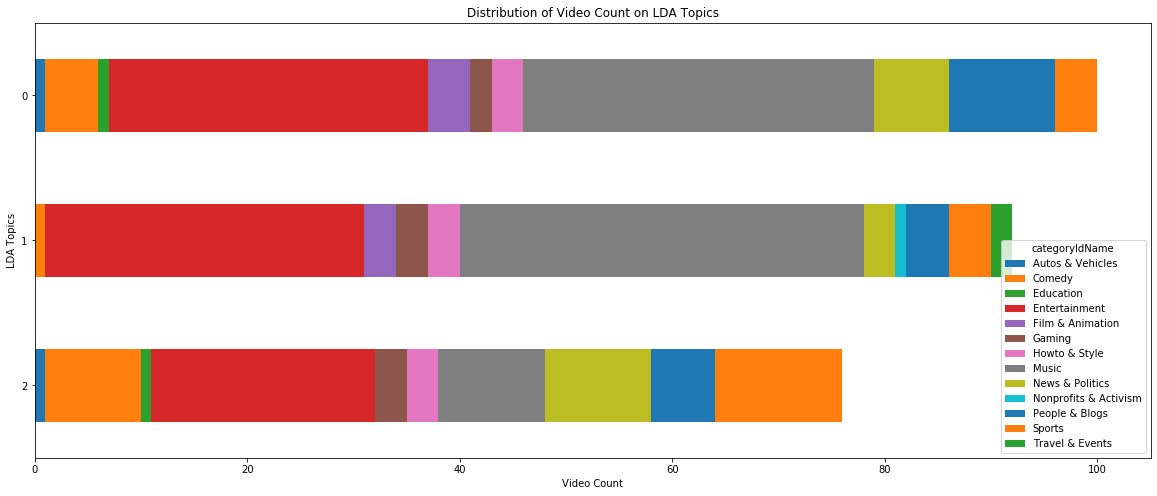

In [156]:
temp = no_dups_l.groupby(['lda_topic', 'categoryIdName']).agg('count')['video_id'].reset_index()
temp.sort_values('video_id', inplace = True, ascending = False)
def replace_empty(x):
    if x == '':
        return 'N/A'
    else:
        return x
    
temp['lda_topic'] = temp['lda_topic'].apply(lambda x: replace_empty(x))
temp['video_id'] = temp['video_id'].astype(int)
temp = temp.pivot(index='lda_topic', columns='categoryIdName', values='video_id')

temp.plot.barh(stacked=True, figsize=(20,8))
plt.gca().invert_yaxis()
plt.xlabel('Video Count')
plt.ylabel('LDA Topics')
plt.title('Distribution of Video Count on LDA Topics');

STTM

In [161]:
from mgp import MovieGroupProcess
import operator

In [170]:
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=50)
y = mgp.fit(data_words, len(vocab))

In stage 0: transferred 196 clusters with 10 clusters populated
In stage 1: transferred 112 clusters with 10 clusters populated
In stage 2: transferred 85 clusters with 10 clusters populated
In stage 3: transferred 84 clusters with 10 clusters populated
In stage 4: transferred 63 clusters with 10 clusters populated
In stage 5: transferred 67 clusters with 10 clusters populated
In stage 6: transferred 55 clusters with 10 clusters populated
In stage 7: transferred 56 clusters with 10 clusters populated
In stage 8: transferred 56 clusters with 10 clusters populated
In stage 9: transferred 64 clusters with 10 clusters populated
In stage 10: transferred 69 clusters with 10 clusters populated
In stage 11: transferred 68 clusters with 10 clusters populated
In stage 12: transferred 58 clusters with 10 clusters populated
In stage 13: transferred 66 clusters with 10 clusters populated
In stage 14: transferred 55 clusters with 10 clusters populated
In stage 15: transferred 54 clusters with 10 clu

In [172]:
for i in range(10):
    print('Cluster ' + str(i))
    print(sorted(mgp.cluster_word_distribution[i].items(),key = operator.itemgetter(1),reverse = True)[:10])
    print('*' * 20)

Cluster 0
[('like', 21), ('blackpink', 19), ('dance', 12), ('cover', 11), ('serie', 5), ('kpop', 5), ('public', 5), ('video', 4), ('house', 4), ('juventus', 3)]
********************
Cluster 1
[('highlights', 14), ('premier', 6), ('league', 6), ('city', 5), ('manchester', 3), ('everton', 3), ('brighton', 3), ('arsenal', 3), ('man', 2), ('liverpool', 2)]
********************
Cluster 2
[('sekolah', 6), ('rumah', 5), ('kei', 4), ('makanan', 4), ('diy', 4), ('trik', 4), ('keluarga', 3), ('fakta', 3), ('kiat', 3), ('nus', 2)]
********************
Cluster 3
[('2020', 15), ('indonesia', 7), ('terbaru', 6), ('full', 4), ('movie', 4), ('film', 3), ('lagu', 3), ('20', 3), ('weird', 3), ('gak', 3)]
********************
Cluster 4
[('video', 24), ('official', 23), ('music', 14), ('lyric', 7), ('terlanjurmencinta', 6), ('live', 4), ('aurelie', 3), ('hermansyah', 3), ('kepastian', 3), ('tiara', 3)]
********************
Cluster 5
[('episode', 8), ('laudya', 4), ('cynthia', 4), ('bella', 4), ('wulan', 4

In [177]:
topics = []
for i in range(len(data_words)):
    topics.append(mgp.choose_best_label(data_words[i])[0])
    
no_dups_l['sttm_topic'] = topics

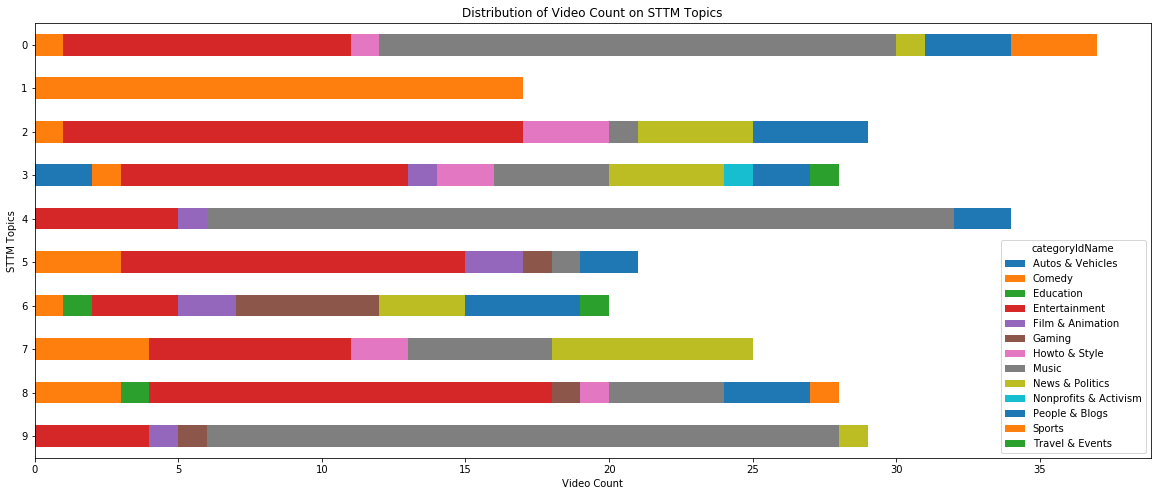

In [179]:
temp = no_dups_l.groupby(['sttm_topic', 'categoryIdName']).agg('count')['video_id'].reset_index()
temp.sort_values('video_id', inplace = True, ascending = False)
def replace_empty(x):
    if x == '':
        return 'N/A'
    else:
        return x
    
temp['sttm_topic'] = temp['sttm_topic'].apply(lambda x: replace_empty(x))
temp['video_id'] = temp['video_id'].astype(int)
temp = temp.pivot(index='sttm_topic', columns='categoryIdName', values='video_id')

temp.plot.barh(stacked=True, figsize=(20,8))
plt.gca().invert_yaxis()
plt.xlabel('Video Count')
plt.ylabel('STTM Topics')
plt.title('Distribution of Video Count on STTM Topics');

Thumbnail Analysis

In [49]:
def download_images(thumbnail_link, idx):
    print(thumbnail_link)
    urllib.request.urlretrieve(thumbnail_link, 'thumbnail_images/' + str(idx) + '.jpg')

In [50]:
# download images in parallel
Parallel(n_jobs=-1, require='sharedmem')(delayed(download_images)(elem, ind) for ind, elem in enumerate(no_dups_l['thumbnail_link'].values));

https://i.ytimg.com/vi/KXgsdivgobg/default.jpghttps://i.ytimg.com/vi/p9VvVbqGpKw/default.jpghttps://i.ytimg.com/vi/qmnc_RbJ4AM/default.jpghttps://i.ytimg.com/vi/1qZqDPS5Nl4/default.jpg



https://i.ytimg.com/vi/zac9JY1aLtk/default.jpg
https://i.ytimg.com/vi/EasWagnJvSI/default.jpghttps://i.ytimg.com/vi/ASbxgpt4nV4/default.jpg

https://i.ytimg.com/vi/s1Fo7KPVJKw/default.jpg
https://i.ytimg.com/vi/mJyShfMj9MY/default.jpg
https://i.ytimg.com/vi/-AOxqMNEOG4/default.jpg
https://i.ytimg.com/vi/LCPla0uOSq4/default.jpg
https://i.ytimg.com/vi/I3t1NSSJxYo/default.jpghttps://i.ytimg.com/vi/KBAqBRA4L-o/default.jpg

https://i.ytimg.com/vi/2u8RCQxlF54/default.jpg
https://i.ytimg.com/vi/l_As0OhjPQE/default.jpg
https://i.ytimg.com/vi/R-idez11ZIU/default.jpg
https://i.ytimg.com/vi/AGu1PqSM-9o/default.jpg
https://i.ytimg.com/vi/_3PPkdxz3vM/default.jpghttps://i.ytimg.com/vi/7_e6j_mPQio/default.jpg

https://i.ytimg.com/vi/ZPZTYYC31EY/default.jpg
https://i.ytimg.com/vi/JLOwA3o6Zr0/default.jpg
https://i.yti

https://i.ytimg.com/vi/qnsUwZTB2Bo/default.jpg
https://i.ytimg.com/vi/hikiYKKllF0/default.jpg
https://i.ytimg.com/vi/ZeyAxRlBbSI/default.jpg
https://i.ytimg.com/vi/U8LaUKcoqgM/default.jpg
https://i.ytimg.com/vi/M7FZX5qBOQM/default.jpg
https://i.ytimg.com/vi/XZSv3aMGg5Q/default.jpg
https://i.ytimg.com/vi/_EBAR9K69C4/default.jpg
https://i.ytimg.com/vi/m64Q3tlaBkE/default.jpghttps://i.ytimg.com/vi/ou1QDPCcalM/default.jpg

https://i.ytimg.com/vi/mpN-ZobS1Fg/default.jpg
https://i.ytimg.com/vi/qY9YBDK4tjg/default.jpg
https://i.ytimg.com/vi/jU-ie4wfOsI/default.jpg
https://i.ytimg.com/vi/i3Uai46WLjc/default.jpg
https://i.ytimg.com/vi/9IO-Jr0O3d4/default.jpg
https://i.ytimg.com/vi/fXr1VX5Hthk/default.jpg
https://i.ytimg.com/vi/MKPsfVU4Mxo/default.jpg
https://i.ytimg.com/vi/46OYnIvOBuo/default.jpg
https://i.ytimg.com/vi/MLGrZO9mryY/default.jpg
https://i.ytimg.com/vi/7jLA1H9qRvM/default.jpg
https://i.ytimg.com/vi/c6a9I5cME7M/default.jpg
https://i.ytimg.com/vi/32si5cfrCNc/default.jpg
https://i.yti

In [238]:
import cv2
net = cv2.dnn.readNetFromDarknet('darknet/cfg/yolov3.cfg', 'darknet/yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)   #GPU = cv2.dnn.DNN_TARGET_OPENCL_FP16, CPU = DNN_TARGET_CPU

In [239]:
inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image
confThreshold = 0.2  #Confidence threshold
nmsThreshold = 0.2  #Non-maximum suppression threshold

classes = ['person','bicycle','car','motorbike','aeroplane','bus','train','truck','boat','traffic light','fire hydrant',
           'stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow','elephant','bear','zebra',
           'giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite',
           'baseball bat','baseball glove','skateboard','surfboard','tennis racket','bottle','wine glass','cup','fork',
           'knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut',
           'cake','chair','sofa','pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse','remote',
           'keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors',
           'teddy bear','hair drier','toothbrush' ]

In [240]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [241]:
# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [242]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs, list_predictions):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    if len(indices) >= 1:
        list_predictions.append(indices)
    else:
        list_predictions.append([])
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)
    return list_predictions

In [243]:
def main_generate_prediction(input_path, output_path, list_predictions):
    # image file
    cap = cv2.imread(input_path)
    cap = cv2.resize(cap, (480,360))
    
    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(cap, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    # Sets the input to the network
    net.setInput(blob)
    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))
    # Remove the bounding boxes with low confidence
    list_predictions = postprocess(cap, outs, list_predictions)
    
    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    print(label)
    
    # Write the frame with the detection boxes
    cv2.imwrite(output_path, cap.astype(np.uint8));
    
    return list_predictions

In [244]:
list_predictions = []

all_images = os.listdir('thumbnail_images')
for elem in all_images:
    print(elem)
    list_dictions = main_generate_prediction('thumbnail_images/' + elem,'thumbnail_images_out/' + elem, list_predictions)

0.jpg
Inference time: 867.39 ms
1.jpg
Inference time: 903.90 ms
10.jpg
Inference time: 1019.08 ms
100.jpg
Inference time: 936.60 ms
101.jpg
Inference time: 912.41 ms
102.jpg
Inference time: 868.93 ms
103.jpg
Inference time: 891.05 ms
104.jpg
Inference time: 867.74 ms
105.jpg
Inference time: 869.11 ms
106.jpg
Inference time: 875.78 ms
107.jpg
Inference time: 824.30 ms
108.jpg
Inference time: 886.00 ms
109.jpg
Inference time: 866.18 ms
11.jpg
Inference time: 905.89 ms
110.jpg
Inference time: 890.28 ms
111.jpg
Inference time: 825.62 ms
112.jpg
Inference time: 875.41 ms
113.jpg
Inference time: 925.81 ms
114.jpg
Inference time: 966.16 ms
115.jpg
Inference time: 973.80 ms
116.jpg
Inference time: 966.75 ms
117.jpg
Inference time: 968.47 ms
118.jpg
Inference time: 938.89 ms
119.jpg
Inference time: 917.65 ms
12.jpg
Inference time: 943.42 ms
120.jpg
Inference time: 953.61 ms
121.jpg
Inference time: 949.50 ms
122.jpg
Inference time: 957.87 ms
123.jpg
Inference time: 954.01 ms
124.jpg
Inference ti

Inference time: 985.51 ms
77.jpg
Inference time: 961.36 ms
78.jpg
Inference time: 885.68 ms
79.jpg
Inference time: 964.26 ms
8.jpg
Inference time: 947.36 ms
80.jpg
Inference time: 967.17 ms
81.jpg
Inference time: 954.41 ms
82.jpg
Inference time: 974.71 ms
83.jpg
Inference time: 961.79 ms
84.jpg
Inference time: 979.16 ms
85.jpg
Inference time: 974.16 ms
86.jpg
Inference time: 913.17 ms
87.jpg
Inference time: 896.56 ms
88.jpg
Inference time: 974.39 ms
89.jpg
Inference time: 961.63 ms
9.jpg
Inference time: 945.86 ms
90.jpg
Inference time: 947.72 ms
91.jpg
Inference time: 965.62 ms
92.jpg
Inference time: 939.10 ms
93.jpg
Inference time: 962.76 ms
94.jpg
Inference time: 922.99 ms
95.jpg
Inference time: 899.05 ms
96.jpg
Inference time: 971.50 ms
97.jpg
Inference time: 1081.11 ms
98.jpg
Inference time: 1059.44 ms
99.jpg
Inference time: 1024.72 ms


In [251]:
def unravel(x):
    if len(x) == 0:
        return x
    else:
        return x.ravel() 


list_predictions = [unravel(elem) for elem in list_predictions]

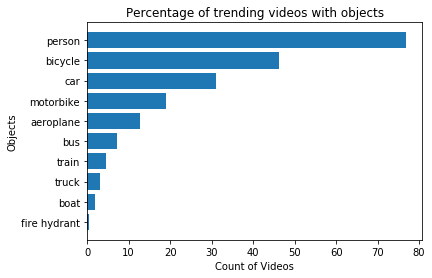

In [274]:
def counter(x):
    all_uniq = set()
    # get all unique labels
    for elem in x:
        for elem2 in elem:
            all_uniq.add(elem2)
    
    counts = {}
    # initialize dict
    for elem in all_uniq:
        counts[elem] = 0
    
    # add counts
    for elem in x:
        for elem2 in elem:
            counts[elem2] += 1
    
    return counts

hist_images = counter(list_predictions)
obj_labels = [classes[elem] for elem in hist_images.keys()]
perc = [elem * 100 / len(list_predictions) for elem in hist_images.values()]
plt.barh(obj_labels, perc)
plt.gca().invert_yaxis()
plt.xlabel('Count of Videos')
plt.ylabel('Objects')
plt.title('Percentage of trending videos with objects');